In [1]:
import afqinsight.nn.tf_models as nn
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
from afqinsight.datasets import AFQDataset
from afqinsight.nn.tf_models import cnn_lenet, mlp4, cnn_vgg, lstm1v0, lstm1, lstm2, blstm1, blstm2, lstm_fcn, cnn_resnet
from sklearn.impute import SimpleImputer
import os.path
# Harmonization
from sklearn.model_selection import train_test_split
from neurocombat_sklearn import CombatModel
from sklearn.utils import shuffle

In [2]:
afq_dataset = AFQDataset.from_files(
    fn_nodes="../data/raw/combined_tract_profiles.csv",
    fn_subjects="../data/raw/participants_updated_id.csv",
    dwi_metrics=["dki_fa", "dki_md", "dki_mk"],
    index_col="subject_id",
    target_cols=["age", "dl_qc_score", "scan_site_id"],
    label_encode_cols=["scan_site_id"]
)

In [3]:
afq_dataset.drop_target_na()

In [4]:
print(len(afq_dataset.subjects))
print(afq_dataset.X.shape)
print(afq_dataset.y.shape)

1865
(1865, 7200)
(1865, 3)


In [5]:
full_dataset = list(afq_dataset.as_tensorflow_dataset().as_numpy_iterator())

2022-03-30 15:32:40.229031: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
X = np.concatenate([xx[0][None] for xx in full_dataset], 0)
y = np.array([yy[1][0] for yy in full_dataset])
qc = np.array([yy[1][1] for yy in full_dataset])
site = np.array([yy[1][2] for yy in full_dataset])

In [7]:
X = X[qc>0]
y = y[qc>0]
site = site[qc>0]

In [8]:
print(site.shape)
print(X.shape)
print(y.shape)

(1817,)
(1817, 100, 72)
(1817,)


In [9]:
import seaborn as sns
import pandas as pd

In [10]:
data = pd.DataFrame(dict(age=y, site=site))

<AxesSubplot:xlabel='age', ylabel='Count'>

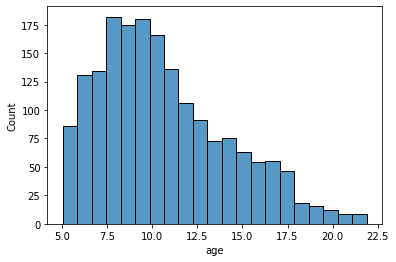

In [11]:
sns.histplot(data=data, x="age")

<AxesSubplot:xlabel='site', ylabel='Count'>

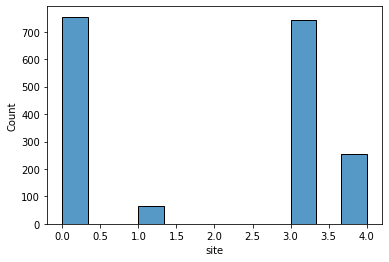

In [12]:
sns.histplot(data=data, x="site")

<AxesSubplot:xlabel='age', ylabel='Count'>

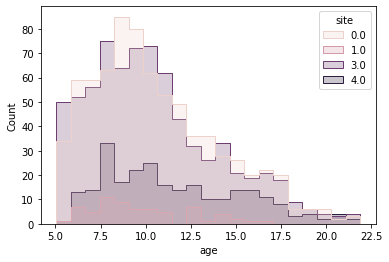

In [13]:
sns.histplot(data=data, x="age", hue="site", element='step')

In [14]:
age_groups = (y/4).astype(int)

In [15]:
X0 = X[site==0]
X1 = X[site==1]
X3 = X[site==3]
X4 = X[site==4]

y0 = y[site==0]
y1 = y[site==1]
y3 = y[site==3]
y4 = y[site==4]

age_groups0 = age_groups[site==0]
age_groups1 = age_groups[site==1]
age_groups3 = age_groups[site==3]
age_groups4 = age_groups[site==4]

In [16]:
X0.shape, y0.shape

((755, 100, 72), (755,))

In [17]:
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.2, stratify=age_groups0, random_state=42)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, stratify=age_groups1, random_state=42)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, stratify=age_groups3, random_state=42)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, stratify=age_groups4, random_state=42)

In [18]:
X0_train.shape, X1_train.shape, X3_train.shape, X4_train.shape

((604, 100, 72), (52, 100, 72), (594, 100, 72), (202, 100, 72))

In [19]:
imputer = SimpleImputer(strategy="median")

In [20]:
def impute(X_train, X_test):
    X_train = np.concatenate([imputer.fit_transform(X_train[..., ii])[:, :, None] for ii in range(X_train.shape[-1])], -1)
    X_test = np.concatenate([imputer.fit_transform(X_test[..., ii])[:, :, None] for ii in range(X_test.shape[-1])], -1)
    return X_train, X_test

In [21]:
X0_train, X0_test = impute(X0_train, X0_test)
X1_train, X1_test = impute(X1_train, X1_test)
X3_train, X3_test = impute(X3_train, X3_test)
X4_train, X4_test = impute(X4_train, X4_test)

In [22]:
n_epochs = 1000

# EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    mode="min",
    patience=100
)

# ReduceLROnPlateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=20,
    verbose=1,
)

In [23]:
model_name=cnn_resnet
lr = 0.01
ckpt_filepath = '/Users/arokem/tmp/chkpt.h5'

In [24]:
X0_train.shape

(604, 100, 72)

In [25]:
this_X0_train, this_y0_train = shuffle(X0_train, y0_train, n_samples=404)

In [26]:
log = tf.keras.callbacks.CSVLogger(filename=(str(model_name) + '.csv'), append=True)

model = model_name(input_shape=(100, 72), n_classes=1, output_activation=None, verbose=True)
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              metrics=['mean_squared_error', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mean_absolute_error'])


ckpt = tf.keras.callbacks.ModelCheckpoint(
    ckpt_filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
)

callbacks = [early_stopping, ckpt, reduce_lr]
history = model.fit(this_X0_train, this_y0_train, epochs=n_epochs, batch_size=128, validation_split=0.2,
                    callbacks=callbacks)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 72)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 100, 64)      36928       ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 100, 64)     256         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 100, 64)      0           ['batch_normalization[0][0]']

3/3 [==============================] - ETA: 0s - loss: 79.3322 - mean_squared_error: 79.3322 - rmse: 8.9069 - mean_absolute_error: 8.2502  
Epoch 00001: val_loss improved from inf to 14176883.00000, saving model to /Users/arokem/tmp/chkpt.h5
3/3 [==============================] - 3s 428ms/step - loss: 79.3322 - mean_squared_error: 79.3322 - rmse: 8.9069 - mean_absolute_error: 8.2502 - val_loss: 14176883.0000 - val_mean_squared_error: 14176883.0000 - val_rmse: 3765.2202 - val_mean_absolute_error: 3753.7913 - lr: 0.0100
Epoch 2/1000
3/3 [==============================] - ETA: 0s - loss: 32.2799 - mean_squared_error: 32.2799 - rmse: 5.6815 - mean_absolute_error: 4.3938
Epoch 00002: val_loss did not improve from 14176883.00000
3/3 [==============================] - 1s 301ms/step - loss: 32.2799 - mean_squared_error: 32.2799 - rmse: 5.6815 - mean_absolute_error: 4.3938 - val_loss: 394557856.0000 - val_mean_squared_error: 394557856.0000 - val_rmse: 19863.4805 - val_mean_absolute_error: 19806

Epoch 33/1000
3/3 [==============================] - ETA: 0s - loss: 0.9784 - mean_squared_error: 0.9784 - rmse: 0.9891 - mean_absolute_error: 0.7839
Epoch 00033: val_loss improved from 76.75768 to 25.80627, saving model to /Users/arokem/tmp/chkpt.h5
3/3 [==============================] - 1s 379ms/step - loss: 0.9784 - mean_squared_error: 0.9784 - rmse: 0.9891 - mean_absolute_error: 0.7839 - val_loss: 25.8063 - val_mean_squared_error: 25.8063 - val_rmse: 5.0800 - val_mean_absolute_error: 4.3039 - lr: 0.0100
Epoch 34/1000
3/3 [==============================] - ETA: 0s - loss: 0.6985 - mean_squared_error: 0.6985 - rmse: 0.8358 - mean_absolute_error: 0.6051
Epoch 00034: val_loss did not improve from 25.80627
3/3 [==============================] - 1s 299ms/step - loss: 0.6985 - mean_squared_error: 0.6985 - rmse: 0.8358 - mean_absolute_error: 0.6051 - val_loss: 27.1813 - val_mean_squared_error: 27.1813 - val_rmse: 5.2136 - val_mean_absolute_error: 4.4596 - lr: 0.0100
Epoch 35/1000
3/3 [====

Epoch 51/1000
3/3 [==============================] - ETA: 0s - loss: 0.1695 - mean_squared_error: 0.1695 - rmse: 0.4117 - mean_absolute_error: 0.3221
Epoch 00051: val_loss did not improve from 8.28072
3/3 [==============================] - 1s 287ms/step - loss: 0.1695 - mean_squared_error: 0.1695 - rmse: 0.4117 - mean_absolute_error: 0.3221 - val_loss: 12.4467 - val_mean_squared_error: 12.4467 - val_rmse: 3.5280 - val_mean_absolute_error: 2.5849 - lr: 0.0100
Epoch 52/1000
3/3 [==============================] - ETA: 0s - loss: 0.2042 - mean_squared_error: 0.2042 - rmse: 0.4519 - mean_absolute_error: 0.3322
Epoch 00052: val_loss did not improve from 8.28072
3/3 [==============================] - 1s 390ms/step - loss: 0.2042 - mean_squared_error: 0.2042 - rmse: 0.4519 - mean_absolute_error: 0.3322 - val_loss: 25.0324 - val_mean_squared_error: 25.0324 - val_rmse: 5.0032 - val_mean_absolute_error: 4.1356 - lr: 0.0100
Epoch 53/1000
3/3 [==============================] - ETA: 0s - loss: 0.226

Epoch 69/1000
3/3 [==============================] - ETA: 0s - loss: 0.2538 - mean_squared_error: 0.2538 - rmse: 0.5037 - mean_absolute_error: 0.3542
Epoch 00069: val_loss did not improve from 8.28072
3/3 [==============================] - 1s 260ms/step - loss: 0.2538 - mean_squared_error: 0.2538 - rmse: 0.5037 - mean_absolute_error: 0.3542 - val_loss: 14.9981 - val_mean_squared_error: 14.9981 - val_rmse: 3.8727 - val_mean_absolute_error: 3.0174 - lr: 0.0050
Epoch 70/1000
3/3 [==============================] - ETA: 0s - loss: 0.0901 - mean_squared_error: 0.0901 - rmse: 0.3002 - mean_absolute_error: 0.2207
Epoch 00070: val_loss did not improve from 8.28072
3/3 [==============================] - 1s 275ms/step - loss: 0.0901 - mean_squared_error: 0.0901 - rmse: 0.3002 - mean_absolute_error: 0.2207 - val_loss: 10.7922 - val_mean_squared_error: 10.7922 - val_rmse: 3.2851 - val_mean_absolute_error: 2.3544 - lr: 0.0050
Epoch 71/1000
3/3 [==============================] - ETA: 0s - loss: 0.078

Epoch 104/1000
3/3 [==============================] - ETA: 0s - loss: 0.0555 - mean_squared_error: 0.0555 - rmse: 0.2356 - mean_absolute_error: 0.1878
Epoch 00104: val_loss did not improve from 5.99197
3/3 [==============================] - 1s 239ms/step - loss: 0.0555 - mean_squared_error: 0.0555 - rmse: 0.2356 - mean_absolute_error: 0.1878 - val_loss: 7.3485 - val_mean_squared_error: 7.3485 - val_rmse: 2.7108 - val_mean_absolute_error: 2.0573 - lr: 0.0012
Epoch 105/1000
3/3 [==============================] - ETA: 0s - loss: 0.0824 - mean_squared_error: 0.0824 - rmse: 0.2870 - mean_absolute_error: 0.2347
Epoch 00105: val_loss did not improve from 5.99197
3/3 [==============================] - 1s 241ms/step - loss: 0.0824 - mean_squared_error: 0.0824 - rmse: 0.2870 - mean_absolute_error: 0.2347 - val_loss: 7.9555 - val_mean_squared_error: 7.9555 - val_rmse: 2.8205 - val_mean_absolute_error: 2.1581 - lr: 0.0012
Epoch 106/1000
3/3 [==============================] - ETA: 0s - loss: 0.1177

Epoch 122/1000
3/3 [==============================] - ETA: 0s - loss: 0.2551 - mean_squared_error: 0.2551 - rmse: 0.5050 - mean_absolute_error: 0.4294
Epoch 00122: val_loss did not improve from 4.28391
3/3 [==============================] - 1s 260ms/step - loss: 0.2551 - mean_squared_error: 0.2551 - rmse: 0.5050 - mean_absolute_error: 0.4294 - val_loss: 6.0097 - val_mean_squared_error: 6.0097 - val_rmse: 2.4515 - val_mean_absolute_error: 1.7942 - lr: 0.0012
Epoch 123/1000
3/3 [==============================] - ETA: 0s - loss: 0.0648 - mean_squared_error: 0.0648 - rmse: 0.2545 - mean_absolute_error: 0.2033
Epoch 00123: val_loss did not improve from 4.28391
3/3 [==============================] - 1s 283ms/step - loss: 0.0648 - mean_squared_error: 0.0648 - rmse: 0.2545 - mean_absolute_error: 0.2033 - val_loss: 5.9267 - val_mean_squared_error: 5.9267 - val_rmse: 2.4345 - val_mean_absolute_error: 1.7721 - lr: 0.0012
Epoch 124/1000
3/3 [==============================] - ETA: 0s - loss: 0.2617

Epoch 140/1000
3/3 [==============================] - ETA: 0s - loss: 0.0859 - mean_squared_error: 0.0859 - rmse: 0.2931 - mean_absolute_error: 0.2364
Epoch 00140: val_loss did not improve from 4.13221
3/3 [==============================] - 1s 279ms/step - loss: 0.0859 - mean_squared_error: 0.0859 - rmse: 0.2931 - mean_absolute_error: 0.2364 - val_loss: 4.8441 - val_mean_squared_error: 4.8441 - val_rmse: 2.2009 - val_mean_absolute_error: 1.6055 - lr: 0.0012
Epoch 141/1000
3/3 [==============================] - ETA: 0s - loss: 0.0771 - mean_squared_error: 0.0771 - rmse: 0.2776 - mean_absolute_error: 0.2369
Epoch 00141: val_loss did not improve from 4.13221
3/3 [==============================] - 1s 309ms/step - loss: 0.0771 - mean_squared_error: 0.0771 - rmse: 0.2776 - mean_absolute_error: 0.2369 - val_loss: 4.2194 - val_mean_squared_error: 4.2194 - val_rmse: 2.0541 - val_mean_absolute_error: 1.5378 - lr: 0.0012
Epoch 142/1000
3/3 [==============================] - ETA: 0s - loss: 0.0398

Epoch 158/1000
3/3 [==============================] - ETA: 0s - loss: 0.1400 - mean_squared_error: 0.1400 - rmse: 0.3742 - mean_absolute_error: 0.3040
Epoch 00158: val_loss did not improve from 4.13221
3/3 [==============================] - 1s 302ms/step - loss: 0.1400 - mean_squared_error: 0.1400 - rmse: 0.3742 - mean_absolute_error: 0.3040 - val_loss: 5.0205 - val_mean_squared_error: 5.0205 - val_rmse: 2.2407 - val_mean_absolute_error: 1.6448 - lr: 6.2500e-04
Epoch 159/1000
3/3 [==============================] - ETA: 0s - loss: 0.1130 - mean_squared_error: 0.1130 - rmse: 0.3361 - mean_absolute_error: 0.2752
Epoch 00159: val_loss did not improve from 4.13221
3/3 [==============================] - 1s 299ms/step - loss: 0.1130 - mean_squared_error: 0.1130 - rmse: 0.3361 - mean_absolute_error: 0.2752 - val_loss: 4.9856 - val_mean_squared_error: 4.9856 - val_rmse: 2.2329 - val_mean_absolute_error: 1.6413 - lr: 6.2500e-04
Epoch 160/1000
3/3 [==============================] - ETA: 0s - loss

Epoch 176/1000
3/3 [==============================] - ETA: 0s - loss: 0.0245 - mean_squared_error: 0.0245 - rmse: 0.1564 - mean_absolute_error: 0.1168
Epoch 00176: val_loss did not improve from 4.13221

Epoch 00176: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.
3/3 [==============================] - 1s 279ms/step - loss: 0.0245 - mean_squared_error: 0.0245 - rmse: 0.1564 - mean_absolute_error: 0.1168 - val_loss: 4.7385 - val_mean_squared_error: 4.7385 - val_rmse: 2.1768 - val_mean_absolute_error: 1.6252 - lr: 6.2500e-04
Epoch 177/1000
3/3 [==============================] - ETA: 0s - loss: 0.1469 - mean_squared_error: 0.1469 - rmse: 0.3833 - mean_absolute_error: 0.3217
Epoch 00177: val_loss did not improve from 4.13221
3/3 [==============================] - 1s 253ms/step - loss: 0.1469 - mean_squared_error: 0.1469 - rmse: 0.3833 - mean_absolute_error: 0.3217 - val_loss: 4.7571 - val_mean_squared_error: 4.7571 - val_rmse: 2.1811 - val_mean_absolute_error: 1.6299 - lr

Epoch 194/1000
3/3 [==============================] - ETA: 0s - loss: 0.0320 - mean_squared_error: 0.0320 - rmse: 0.1789 - mean_absolute_error: 0.1400
Epoch 00194: val_loss did not improve from 4.13221
3/3 [==============================] - 1s 277ms/step - loss: 0.0320 - mean_squared_error: 0.0320 - rmse: 0.1789 - mean_absolute_error: 0.1400 - val_loss: 4.3392 - val_mean_squared_error: 4.3392 - val_rmse: 2.0831 - val_mean_absolute_error: 1.5702 - lr: 3.1250e-04
Epoch 195/1000
3/3 [==============================] - ETA: 0s - loss: 0.0964 - mean_squared_error: 0.0964 - rmse: 0.3106 - mean_absolute_error: 0.2445
Epoch 00195: val_loss did not improve from 4.13221
3/3 [==============================] - 1s 258ms/step - loss: 0.0964 - mean_squared_error: 0.0964 - rmse: 0.3106 - mean_absolute_error: 0.2445 - val_loss: 4.3055 - val_mean_squared_error: 4.3055 - val_rmse: 2.0750 - val_mean_absolute_error: 1.5690 - lr: 3.1250e-04
Epoch 196/1000
3/3 [==============================] - ETA: 0s - loss

Epoch 212/1000
3/3 [==============================] - ETA: 0s - loss: 0.1869 - mean_squared_error: 0.1869 - rmse: 0.4323 - mean_absolute_error: 0.3174
Epoch 00212: val_loss did not improve from 4.13221
3/3 [==============================] - 1s 270ms/step - loss: 0.1869 - mean_squared_error: 0.1869 - rmse: 0.4323 - mean_absolute_error: 0.3174 - val_loss: 4.3037 - val_mean_squared_error: 4.3037 - val_rmse: 2.0745 - val_mean_absolute_error: 1.5919 - lr: 1.5625e-04
Epoch 213/1000
3/3 [==============================] - ETA: 0s - loss: 0.2252 - mean_squared_error: 0.2252 - rmse: 0.4745 - mean_absolute_error: 0.3587
Epoch 00213: val_loss did not improve from 4.13221
3/3 [==============================] - 1s 254ms/step - loss: 0.2252 - mean_squared_error: 0.2252 - rmse: 0.4745 - mean_absolute_error: 0.3587 - val_loss: 4.3050 - val_mean_squared_error: 4.3050 - val_rmse: 2.0749 - val_mean_absolute_error: 1.5996 - lr: 1.5625e-04
Epoch 214/1000
3/3 [==============================] - ETA: 0s - loss

Epoch 230/1000
3/3 [==============================] - ETA: 0s - loss: 0.2141 - mean_squared_error: 0.2141 - rmse: 0.4627 - mean_absolute_error: 0.3520
Epoch 00230: val_loss did not improve from 4.13221
3/3 [==============================] - 1s 249ms/step - loss: 0.2141 - mean_squared_error: 0.2141 - rmse: 0.4627 - mean_absolute_error: 0.3520 - val_loss: 4.3950 - val_mean_squared_error: 4.3950 - val_rmse: 2.0964 - val_mean_absolute_error: 1.5861 - lr: 7.8125e-05
Epoch 231/1000
3/3 [==============================] - ETA: 0s - loss: 0.0548 - mean_squared_error: 0.0548 - rmse: 0.2341 - mean_absolute_error: 0.1734
Epoch 00231: val_loss did not improve from 4.13221
3/3 [==============================] - 1s 229ms/step - loss: 0.0548 - mean_squared_error: 0.0548 - rmse: 0.2341 - mean_absolute_error: 0.1734 - val_loss: 4.4091 - val_mean_squared_error: 4.4091 - val_rmse: 2.0998 - val_mean_absolute_error: 1.5870 - lr: 7.8125e-05
Epoch 232/1000
3/3 [==============================] - ETA: 0s - loss

In [27]:
model.load_weights(ckpt_filepath)
mae1 = model.evaluate(X0_test, y0_test)[3]

5/5 [==============================] - 0s 18ms/step - loss: 4.6823 - mean_squared_error: 4.6823 - rmse: 2.1639 - mean_absolute_error: 1.7362


In [28]:
this_X3_train, this_y3_train = shuffle(X3_train, y3_train, n_samples=404)

In [29]:
log = tf.keras.callbacks.CSVLogger(filename=(str(model_name) + '.csv'), append=True)

model = model_name(input_shape=(100, 72), n_classes=1, output_activation=None, verbose=True)
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              metrics=['mean_squared_error', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mean_absolute_error'])


ckpt = tf.keras.callbacks.ModelCheckpoint(
    ckpt_filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
)

callbacks = [early_stopping, ckpt, reduce_lr]
history = model.fit(this_X3_train, this_y3_train, epochs=n_epochs, batch_size=128, validation_split=0.2,
                    callbacks=callbacks)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 72)]    0           []                               
                                                                                                  
 conv1d_11 (Conv1D)             (None, 100, 64)      36928       ['input_2[0][0]']                
                                                                                                  
 batch_normalization_12 (BatchN  (None, 100, 64)     256         ['conv1d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_12 (Activation)     (None, 100, 64)      0           ['batch_normalization_12[0]

3/3 [==============================] - ETA: 0s - loss: 103.9728 - mean_squared_error: 103.9728 - rmse: 10.1967 - mean_absolute_error: 9.3874
Epoch 00001: val_loss improved from inf to 1060708.12500, saving model to /Users/arokem/tmp/chkpt.h5
3/3 [==============================] - 3s 399ms/step - loss: 103.9728 - mean_squared_error: 103.9728 - rmse: 10.1967 - mean_absolute_error: 9.3874 - val_loss: 1060708.1250 - val_mean_squared_error: 1060708.1250 - val_rmse: 1029.9069 - val_mean_absolute_error: 1015.0021 - lr: 0.0100
Epoch 2/1000
3/3 [==============================] - ETA: 0s - loss: 28.8179 - mean_squared_error: 28.8179 - rmse: 5.3682 - mean_absolute_error: 4.4272
Epoch 00002: val_loss did not improve from 1060708.12500
3/3 [==============================] - 1s 229ms/step - loss: 28.8179 - mean_squared_error: 28.8179 - rmse: 5.3682 - mean_absolute_error: 4.4272 - val_loss: 147310480.0000 - val_mean_squared_error: 147310480.0000 - val_rmse: 12137.1533 - val_mean_absolute_error: 11949

3/3 [==============================] - 1s 235ms/step - loss: 3.0075 - mean_squared_error: 3.0075 - rmse: 1.7342 - mean_absolute_error: 1.3596 - val_loss: 122974.9531 - val_mean_squared_error: 122974.9531 - val_rmse: 350.6779 - val_mean_absolute_error: 335.7198 - lr: 0.0100
Epoch 18/1000
3/3 [==============================] - ETA: 0s - loss: 2.4760 - mean_squared_error: 2.4760 - rmse: 1.5735 - mean_absolute_error: 1.2598
Epoch 00018: val_loss improved from 122974.95312 to 68687.14844, saving model to /Users/arokem/tmp/chkpt.h5
3/3 [==============================] - 1s 240ms/step - loss: 2.4760 - mean_squared_error: 2.4760 - rmse: 1.5735 - mean_absolute_error: 1.2598 - val_loss: 68687.1484 - val_mean_squared_error: 68687.1484 - val_rmse: 262.0823 - val_mean_absolute_error: 250.2982 - lr: 0.0100
Epoch 19/1000
3/3 [==============================] - ETA: 0s - loss: 2.2037 - mean_squared_error: 2.2037 - rmse: 1.4845 - mean_absolute_error: 1.1503
Epoch 00019: val_loss improved from 68687.1484

Epoch 51/1000
3/3 [==============================] - ETA: 0s - loss: 0.6294 - mean_squared_error: 0.6294 - rmse: 0.7933 - mean_absolute_error: 0.6408
Epoch 00051: val_loss did not improve from 10.90584
3/3 [==============================] - 1s 224ms/step - loss: 0.6294 - mean_squared_error: 0.6294 - rmse: 0.7933 - mean_absolute_error: 0.6408 - val_loss: 11.1235 - val_mean_squared_error: 11.1235 - val_rmse: 3.3352 - val_mean_absolute_error: 2.4343 - lr: 0.0100
Epoch 52/1000
3/3 [==============================] - ETA: 0s - loss: 0.5561 - mean_squared_error: 0.5561 - rmse: 0.7457 - mean_absolute_error: 0.5911
Epoch 00052: val_loss improved from 10.90584 to 9.86888, saving model to /Users/arokem/tmp/chkpt.h5
3/3 [==============================] - 1s 232ms/step - loss: 0.5561 - mean_squared_error: 0.5561 - rmse: 0.7457 - mean_absolute_error: 0.5911 - val_loss: 9.8689 - val_mean_squared_error: 9.8689 - val_rmse: 3.1415 - val_mean_absolute_error: 2.3664 - lr: 0.0100
Epoch 53/1000
3/3 [=======

Epoch 86/1000
3/3 [==============================] - ETA: 0s - loss: 0.1027 - mean_squared_error: 0.1027 - rmse: 0.3205 - mean_absolute_error: 0.2525
Epoch 00086: val_loss did not improve from 6.38577
3/3 [==============================] - 1s 270ms/step - loss: 0.1027 - mean_squared_error: 0.1027 - rmse: 0.3205 - mean_absolute_error: 0.2525 - val_loss: 12.0221 - val_mean_squared_error: 12.0221 - val_rmse: 3.4673 - val_mean_absolute_error: 2.8378 - lr: 0.0050
Epoch 87/1000
3/3 [==============================] - ETA: 0s - loss: 0.1962 - mean_squared_error: 0.1962 - rmse: 0.4429 - mean_absolute_error: 0.3453
Epoch 00087: val_loss did not improve from 6.38577
3/3 [==============================] - 1s 260ms/step - loss: 0.1962 - mean_squared_error: 0.1962 - rmse: 0.4429 - mean_absolute_error: 0.3453 - val_loss: 13.9578 - val_mean_squared_error: 13.9578 - val_rmse: 3.7360 - val_mean_absolute_error: 3.0869 - lr: 0.0050
Epoch 88/1000
3/3 [==============================] - ETA: 0s - loss: 0.111

Epoch 104/1000
3/3 [==============================] - ETA: 0s - loss: 0.0398 - mean_squared_error: 0.0398 - rmse: 0.1994 - mean_absolute_error: 0.1571
Epoch 00104: val_loss did not improve from 6.38577
3/3 [==============================] - 1s 258ms/step - loss: 0.0398 - mean_squared_error: 0.0398 - rmse: 0.1994 - mean_absolute_error: 0.1571 - val_loss: 9.4670 - val_mean_squared_error: 9.4670 - val_rmse: 3.0769 - val_mean_absolute_error: 2.4563 - lr: 0.0025
Epoch 105/1000
3/3 [==============================] - ETA: 0s - loss: 0.2883 - mean_squared_error: 0.2883 - rmse: 0.5370 - mean_absolute_error: 0.3543
Epoch 00105: val_loss did not improve from 6.38577
3/3 [==============================] - 1s 256ms/step - loss: 0.2883 - mean_squared_error: 0.2883 - rmse: 0.5370 - mean_absolute_error: 0.3543 - val_loss: 11.5516 - val_mean_squared_error: 11.5516 - val_rmse: 3.3988 - val_mean_absolute_error: 2.7611 - lr: 0.0025
Epoch 106/1000
3/3 [==============================] - ETA: 0s - loss: 0.10

Epoch 122/1000
3/3 [==============================] - ETA: 0s - loss: 0.0476 - mean_squared_error: 0.0476 - rmse: 0.2182 - mean_absolute_error: 0.1708
Epoch 00122: val_loss did not improve from 5.42472
3/3 [==============================] - 1s 250ms/step - loss: 0.0476 - mean_squared_error: 0.0476 - rmse: 0.2182 - mean_absolute_error: 0.1708 - val_loss: 5.9522 - val_mean_squared_error: 5.9522 - val_rmse: 2.4397 - val_mean_absolute_error: 1.8947 - lr: 0.0025
Epoch 123/1000
3/3 [==============================] - ETA: 0s - loss: 0.0453 - mean_squared_error: 0.0453 - rmse: 0.2129 - mean_absolute_error: 0.1725
Epoch 00123: val_loss did not improve from 5.42472
3/3 [==============================] - 1s 378ms/step - loss: 0.0453 - mean_squared_error: 0.0453 - rmse: 0.2129 - mean_absolute_error: 0.1725 - val_loss: 6.8691 - val_mean_squared_error: 6.8691 - val_rmse: 2.6209 - val_mean_absolute_error: 2.0637 - lr: 0.0025
Epoch 124/1000
3/3 [==============================] - ETA: 0s - loss: 0.0269

Epoch 140/1000
3/3 [==============================] - ETA: 0s - loss: 0.0869 - mean_squared_error: 0.0869 - rmse: 0.2948 - mean_absolute_error: 0.2407
Epoch 00140: val_loss did not improve from 5.30293
3/3 [==============================] - 1s 247ms/step - loss: 0.0869 - mean_squared_error: 0.0869 - rmse: 0.2948 - mean_absolute_error: 0.2407 - val_loss: 5.5411 - val_mean_squared_error: 5.5411 - val_rmse: 2.3540 - val_mean_absolute_error: 1.7747 - lr: 0.0012
Epoch 141/1000
3/3 [==============================] - ETA: 0s - loss: 0.2870 - mean_squared_error: 0.2870 - rmse: 0.5357 - mean_absolute_error: 0.3871
Epoch 00141: val_loss did not improve from 5.30293
3/3 [==============================] - 1s 254ms/step - loss: 0.2870 - mean_squared_error: 0.2870 - rmse: 0.5357 - mean_absolute_error: 0.3871 - val_loss: 5.7864 - val_mean_squared_error: 5.7864 - val_rmse: 2.4055 - val_mean_absolute_error: 1.8201 - lr: 0.0012
Epoch 142/1000
3/3 [==============================] - ETA: 0s - loss: 0.1341

Epoch 175/1000
3/3 [==============================] - ETA: 0s - loss: 0.2083 - mean_squared_error: 0.2083 - rmse: 0.4563 - mean_absolute_error: 0.3899
Epoch 00175: val_loss did not improve from 5.01027
3/3 [==============================] - 1s 225ms/step - loss: 0.2083 - mean_squared_error: 0.2083 - rmse: 0.4563 - mean_absolute_error: 0.3899 - val_loss: 5.4893 - val_mean_squared_error: 5.4893 - val_rmse: 2.3429 - val_mean_absolute_error: 1.7448 - lr: 6.2500e-04
Epoch 176/1000
3/3 [==============================] - ETA: 0s - loss: 0.0440 - mean_squared_error: 0.0440 - rmse: 0.2097 - mean_absolute_error: 0.1641
Epoch 00176: val_loss did not improve from 5.01027
3/3 [==============================] - 1s 219ms/step - loss: 0.0440 - mean_squared_error: 0.0440 - rmse: 0.2097 - mean_absolute_error: 0.1641 - val_loss: 5.4763 - val_mean_squared_error: 5.4763 - val_rmse: 2.3401 - val_mean_absolute_error: 1.7398 - lr: 6.2500e-04
Epoch 177/1000
3/3 [==============================] - ETA: 0s - loss

Epoch 193/1000
3/3 [==============================] - ETA: 0s - loss: 0.0988 - mean_squared_error: 0.0988 - rmse: 0.3144 - mean_absolute_error: 0.2156
Epoch 00193: val_loss did not improve from 5.01027
3/3 [==============================] - 1s 228ms/step - loss: 0.0988 - mean_squared_error: 0.0988 - rmse: 0.3144 - mean_absolute_error: 0.2156 - val_loss: 5.7030 - val_mean_squared_error: 5.7030 - val_rmse: 2.3881 - val_mean_absolute_error: 1.7917 - lr: 3.1250e-04
Epoch 194/1000
3/3 [==============================] - ETA: 0s - loss: 0.0968 - mean_squared_error: 0.0968 - rmse: 0.3111 - mean_absolute_error: 0.2528
Epoch 00194: val_loss did not improve from 5.01027
3/3 [==============================] - 1s 214ms/step - loss: 0.0968 - mean_squared_error: 0.0968 - rmse: 0.3111 - mean_absolute_error: 0.2528 - val_loss: 5.6682 - val_mean_squared_error: 5.6682 - val_rmse: 2.3808 - val_mean_absolute_error: 1.7827 - lr: 3.1250e-04
Epoch 195/1000
3/3 [==============================] - ETA: 0s - loss

Epoch 211/1000
3/3 [==============================] - ETA: 0s - loss: 0.2339 - mean_squared_error: 0.2339 - rmse: 0.4836 - mean_absolute_error: 0.3626
Epoch 00211: val_loss did not improve from 5.01027

Epoch 00211: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
3/3 [==============================] - 1s 228ms/step - loss: 0.2339 - mean_squared_error: 0.2339 - rmse: 0.4836 - mean_absolute_error: 0.3626 - val_loss: 5.7151 - val_mean_squared_error: 5.7151 - val_rmse: 2.3906 - val_mean_absolute_error: 1.7696 - lr: 3.1250e-04
Epoch 212/1000
3/3 [==============================] - ETA: 0s - loss: 0.0597 - mean_squared_error: 0.0597 - rmse: 0.2443 - mean_absolute_error: 0.1932
Epoch 00212: val_loss did not improve from 5.01027
3/3 [==============================] - 1s 256ms/step - loss: 0.0597 - mean_squared_error: 0.0597 - rmse: 0.2443 - mean_absolute_error: 0.1932 - val_loss: 5.7272 - val_mean_squared_error: 5.7272 - val_rmse: 2.3931 - val_mean_absolute_error: 1.7720 - l

Epoch 229/1000
3/3 [==============================] - ETA: 0s - loss: 0.0481 - mean_squared_error: 0.0481 - rmse: 0.2192 - mean_absolute_error: 0.1706
Epoch 00229: val_loss did not improve from 5.01027
3/3 [==============================] - 1s 243ms/step - loss: 0.0481 - mean_squared_error: 0.0481 - rmse: 0.2192 - mean_absolute_error: 0.1706 - val_loss: 5.6566 - val_mean_squared_error: 5.6566 - val_rmse: 2.3784 - val_mean_absolute_error: 1.7468 - lr: 1.5625e-04
Epoch 230/1000
3/3 [==============================] - ETA: 0s - loss: 0.0913 - mean_squared_error: 0.0913 - rmse: 0.3022 - mean_absolute_error: 0.2611
Epoch 00230: val_loss did not improve from 5.01027
3/3 [==============================] - 1s 270ms/step - loss: 0.0913 - mean_squared_error: 0.0913 - rmse: 0.3022 - mean_absolute_error: 0.2611 - val_loss: 5.7001 - val_mean_squared_error: 5.7001 - val_rmse: 2.3875 - val_mean_absolute_error: 1.7540 - lr: 1.5625e-04
Epoch 231/1000
3/3 [==============================] - ETA: 0s - loss

Epoch 247/1000
3/3 [==============================] - ETA: 0s - loss: 0.0295 - mean_squared_error: 0.0295 - rmse: 0.1718 - mean_absolute_error: 0.1348
Epoch 00247: val_loss did not improve from 5.01027
3/3 [==============================] - 1s 354ms/step - loss: 0.0295 - mean_squared_error: 0.0295 - rmse: 0.1718 - mean_absolute_error: 0.1348 - val_loss: 5.7022 - val_mean_squared_error: 5.7022 - val_rmse: 2.3879 - val_mean_absolute_error: 1.7543 - lr: 7.8125e-05
Epoch 248/1000
3/3 [==============================] - ETA: 0s - loss: 0.1285 - mean_squared_error: 0.1285 - rmse: 0.3585 - mean_absolute_error: 0.2643
Epoch 00248: val_loss did not improve from 5.01027
3/3 [==============================] - 1s 348ms/step - loss: 0.1285 - mean_squared_error: 0.1285 - rmse: 0.3585 - mean_absolute_error: 0.2643 - val_loss: 5.6934 - val_mean_squared_error: 5.6934 - val_rmse: 2.3861 - val_mean_absolute_error: 1.7522 - lr: 7.8125e-05
Epoch 249/1000
3/3 [==============================] - ETA: 0s - loss

In [30]:
model.load_weights(ckpt_filepath)
model.evaluate(X3_test, y3_test)
generr1 = model.evaluate(X0_test, y0_test)[3] - mae1

5/5 [==============================] - 0s 22ms/step - loss: 25.1958 - mean_squared_error: 25.1958 - rmse: 5.0195 - mean_absolute_error: 4.4237


In [31]:
X0_train.shape, X3_train.shape, X4_train.shape

((604, 100, 72), (594, 100, 72), (202, 100, 72))

In [32]:
this_X3_train, this_y3_train = shuffle(X3_train, y3_train, n_samples=202)

X34_train = np.concatenate([this_X3_train, X4_train], 0)
y34_train = np.concatenate([this_y3_train, y4_train], 0)

this_X34_train, this_y34_train = shuffle(X34_train, y34_train)
this_X34_train.shape

(404, 100, 72)

In [33]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [34]:
model = model_name(input_shape=(100, 72), n_classes=1, output_activation=None, verbose=True)
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              metrics=['mean_squared_error', 
                       tf.keras.metrics.RootMeanSquaredError(name='rmse'), 
                       'mean_absolute_error', 
                       coeff_determination])


ckpt = tf.keras.callbacks.ModelCheckpoint(
    ckpt_filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
)

callbacks = [early_stopping, ckpt, reduce_lr, log]
history = model.fit(this_X34_train, this_y34_train, epochs=n_epochs, batch_size=128, validation_split=0.2,
                    callbacks=callbacks)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 72)]    0           []                               
                                                                                                  
 conv1d_22 (Conv1D)             (None, 100, 64)      36928       ['input_3[0][0]']                
                                                                                                  
 batch_normalization_24 (BatchN  (None, 100, 64)     256         ['conv1d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_24 (Activation)     (None, 100, 64)      0           ['batch_normalization_24[0]

3/3 [==============================] - ETA: 0s - loss: 92.3088 - mean_squared_error: 92.3088 - rmse: 9.6077 - mean_absolute_error: 8.6130 - coeff_determination: -5.3299   
Epoch 00001: val_loss improved from inf to 1041537.31250, saving model to /Users/arokem/tmp/chkpt.h5
3/3 [==============================] - 4s 416ms/step - loss: 92.3088 - mean_squared_error: 92.3088 - rmse: 9.6077 - mean_absolute_error: 8.6130 - coeff_determination: -5.3299 - val_loss: 1041537.3125 - val_mean_squared_error: 1041537.3125 - val_rmse: 1020.5574 - val_mean_absolute_error: 1015.3546 - val_coeff_determination: -71014.5781 - lr: 0.0100
Epoch 2/1000
3/3 [==============================] - ETA: 0s - loss: 23.5042 - mean_squared_error: 23.5042 - rmse: 4.8481 - mean_absolute_error: 3.7770 - coeff_determination: -0.5621
Epoch 00002: val_loss did not improve from 1041537.31250
3/3 [==============================] - 1s 237ms/step - loss: 23.5042 - mean_squared_error: 23.5042 - rmse: 4.8481 - mean_absolute_error: 3

Epoch 15/1000
3/3 [==============================] - ETA: 0s - loss: 3.3740 - mean_squared_error: 3.3740 - rmse: 1.8368 - mean_absolute_error: 1.4462 - coeff_determination: 0.7457
Epoch 00015: val_loss improved from 193231.51562 to 96883.99219, saving model to /Users/arokem/tmp/chkpt.h5
3/3 [==============================] - 1s 362ms/step - loss: 3.3740 - mean_squared_error: 3.3740 - rmse: 1.8368 - mean_absolute_error: 1.4462 - coeff_determination: 0.7457 - val_loss: 96883.9922 - val_mean_squared_error: 96883.9922 - val_rmse: 311.2619 - val_mean_absolute_error: 306.5251 - val_coeff_determination: -6604.8823 - lr: 0.0100
Epoch 16/1000
3/3 [==============================] - ETA: 0s - loss: 3.7103 - mean_squared_error: 3.7103 - rmse: 1.9262 - mean_absolute_error: 1.5318 - coeff_determination: 0.7084
Epoch 00016: val_loss improved from 96883.99219 to 46701.75781, saving model to /Users/arokem/tmp/chkpt.h5
3/3 [==============================] - 1s 384ms/step - loss: 3.7103 - mean_squared_er

Epoch 43/1000
3/3 [==============================] - ETA: 0s - loss: 0.7562 - mean_squared_error: 0.7562 - rmse: 0.8696 - mean_absolute_error: 0.6742 - coeff_determination: 0.9416
Epoch 00043: val_loss did not improve from 8.85266
3/3 [==============================] - 1s 232ms/step - loss: 0.7562 - mean_squared_error: 0.7562 - rmse: 0.8696 - mean_absolute_error: 0.6742 - coeff_determination: 0.9416 - val_loss: 46.4164 - val_mean_squared_error: 46.4164 - val_rmse: 6.8130 - val_mean_absolute_error: 5.7676 - val_coeff_determination: -2.1648 - lr: 0.0100
Epoch 44/1000
3/3 [==============================] - ETA: 0s - loss: 0.8115 - mean_squared_error: 0.8115 - rmse: 0.9008 - mean_absolute_error: 0.7134 - coeff_determination: 0.9369
Epoch 00044: val_loss did not improve from 8.85266
3/3 [==============================] - 1s 251ms/step - loss: 0.8115 - mean_squared_error: 0.8115 - rmse: 0.9008 - mean_absolute_error: 0.7134 - coeff_determination: 0.9369 - val_loss: 71.2667 - val_mean_squared_

Epoch 58/1000
3/3 [==============================] - ETA: 0s - loss: 0.4472 - mean_squared_error: 0.4472 - rmse: 0.6687 - mean_absolute_error: 0.5205 - coeff_determination: 0.9604
Epoch 00058: val_loss did not improve from 8.85266
3/3 [==============================] - 1s 269ms/step - loss: 0.4472 - mean_squared_error: 0.4472 - rmse: 0.6687 - mean_absolute_error: 0.5205 - coeff_determination: 0.9604 - val_loss: 98.3273 - val_mean_squared_error: 98.3273 - val_rmse: 9.9160 - val_mean_absolute_error: 9.3408 - val_coeff_determination: -5.7043 - lr: 0.0050
Epoch 59/1000
3/3 [==============================] - ETA: 0s - loss: 0.2781 - mean_squared_error: 0.2781 - rmse: 0.5273 - mean_absolute_error: 0.4146 - coeff_determination: 0.9798
Epoch 00059: val_loss did not improve from 8.85266
3/3 [==============================] - 1s 302ms/step - loss: 0.2781 - mean_squared_error: 0.2781 - rmse: 0.5273 - mean_absolute_error: 0.4146 - coeff_determination: 0.9798 - val_loss: 106.2759 - val_mean_squared

Epoch 73/1000
3/3 [==============================] - ETA: 0s - loss: 0.3254 - mean_squared_error: 0.3254 - rmse: 0.5705 - mean_absolute_error: 0.4632 - coeff_determination: 0.9772
Epoch 00073: val_loss did not improve from 8.85266
3/3 [==============================] - 1s 268ms/step - loss: 0.3254 - mean_squared_error: 0.3254 - rmse: 0.5705 - mean_absolute_error: 0.4632 - coeff_determination: 0.9772 - val_loss: 79.1815 - val_mean_squared_error: 79.1815 - val_rmse: 8.8984 - val_mean_absolute_error: 8.1656 - val_coeff_determination: -4.3989 - lr: 0.0025
Epoch 74/1000
3/3 [==============================] - ETA: 0s - loss: 0.1878 - mean_squared_error: 0.1878 - rmse: 0.4333 - mean_absolute_error: 0.3339 - coeff_determination: 0.9856
Epoch 00074: val_loss did not improve from 8.85266
3/3 [==============================] - 1s 247ms/step - loss: 0.1878 - mean_squared_error: 0.1878 - rmse: 0.4333 - mean_absolute_error: 0.3339 - coeff_determination: 0.9856 - val_loss: 73.3470 - val_mean_squared_

Epoch 88/1000
3/3 [==============================] - ETA: 0s - loss: 0.1645 - mean_squared_error: 0.1645 - rmse: 0.4056 - mean_absolute_error: 0.3089 - coeff_determination: 0.9862
Epoch 00088: val_loss did not improve from 8.85266
3/3 [==============================] - 1s 311ms/step - loss: 0.1645 - mean_squared_error: 0.1645 - rmse: 0.4056 - mean_absolute_error: 0.3089 - coeff_determination: 0.9862 - val_loss: 48.1140 - val_mean_squared_error: 48.1140 - val_rmse: 6.9364 - val_mean_absolute_error: 6.1598 - val_coeff_determination: -2.2806 - lr: 0.0025
Epoch 89/1000
3/3 [==============================] - ETA: 0s - loss: 0.1905 - mean_squared_error: 0.1905 - rmse: 0.4364 - mean_absolute_error: 0.3102 - coeff_determination: 0.9812
Epoch 00089: val_loss did not improve from 8.85266
3/3 [==============================] - 1s 273ms/step - loss: 0.1905 - mean_squared_error: 0.1905 - rmse: 0.4364 - mean_absolute_error: 0.3102 - coeff_determination: 0.9812 - val_loss: 28.6118 - val_mean_squared_

Epoch 103/1000
3/3 [==============================] - ETA: 0s - loss: 0.1200 - mean_squared_error: 0.1200 - rmse: 0.3464 - mean_absolute_error: 0.2735 - coeff_determination: 0.9899
Epoch 00103: val_loss did not improve from 8.85266
3/3 [==============================] - 1s 234ms/step - loss: 0.1200 - mean_squared_error: 0.1200 - rmse: 0.3464 - mean_absolute_error: 0.2735 - coeff_determination: 0.9899 - val_loss: 30.6942 - val_mean_squared_error: 30.6942 - val_rmse: 5.5402 - val_mean_absolute_error: 4.7392 - val_coeff_determination: -1.0928 - lr: 0.0012
Epoch 104/1000
3/3 [==============================] - ETA: 0s - loss: 0.1136 - mean_squared_error: 0.1136 - rmse: 0.3371 - mean_absolute_error: 0.2474 - coeff_determination: 0.9920
Epoch 00104: val_loss did not improve from 8.85266
3/3 [==============================] - 1s 227ms/step - loss: 0.1136 - mean_squared_error: 0.1136 - rmse: 0.3371 - mean_absolute_error: 0.2474 - coeff_determination: 0.9920 - val_loss: 29.5206 - val_mean_square

Epoch 118/1000
3/3 [==============================] - ETA: 0s - loss: 0.3152 - mean_squared_error: 0.3152 - rmse: 0.5614 - mean_absolute_error: 0.4437 - coeff_determination: 0.9686
Epoch 00118: val_loss did not improve from 8.85266
3/3 [==============================] - 1s 356ms/step - loss: 0.3152 - mean_squared_error: 0.3152 - rmse: 0.5614 - mean_absolute_error: 0.4437 - coeff_determination: 0.9686 - val_loss: 16.4018 - val_mean_squared_error: 16.4018 - val_rmse: 4.0499 - val_mean_absolute_error: 3.3109 - val_coeff_determination: -0.1183 - lr: 6.2500e-04
Epoch 119/1000
3/3 [==============================] - ETA: 0s - loss: 0.1411 - mean_squared_error: 0.1411 - rmse: 0.3756 - mean_absolute_error: 0.2993 - coeff_determination: 0.9893
Epoch 00119: val_loss did not improve from 8.85266
3/3 [==============================] - 1s 306ms/step - loss: 0.1411 - mean_squared_error: 0.1411 - rmse: 0.3756 - mean_absolute_error: 0.2993 - coeff_determination: 0.9893 - val_loss: 13.2521 - val_mean_sq

Epoch 133/1000
3/3 [==============================] - ETA: 0s - loss: 0.1792 - mean_squared_error: 0.1792 - rmse: 0.4233 - mean_absolute_error: 0.3366 - coeff_determination: 0.9865
Epoch 00133: val_loss did not improve from 7.49263
3/3 [==============================] - 1s 219ms/step - loss: 0.1792 - mean_squared_error: 0.1792 - rmse: 0.4233 - mean_absolute_error: 0.3366 - coeff_determination: 0.9865 - val_loss: 8.6723 - val_mean_squared_error: 8.6723 - val_rmse: 2.9449 - val_mean_absolute_error: 2.2965 - val_coeff_determination: 0.4087 - lr: 6.2500e-04
Epoch 134/1000
3/3 [==============================] - ETA: 0s - loss: 0.1063 - mean_squared_error: 0.1063 - rmse: 0.3260 - mean_absolute_error: 0.2605 - coeff_determination: 0.9925
Epoch 00134: val_loss did not improve from 7.49263
3/3 [==============================] - 1s 223ms/step - loss: 0.1063 - mean_squared_error: 0.1063 - rmse: 0.3260 - mean_absolute_error: 0.2605 - coeff_determination: 0.9925 - val_loss: 8.9267 - val_mean_square

Epoch 148/1000
3/3 [==============================] - ETA: 0s - loss: 0.2019 - mean_squared_error: 0.2019 - rmse: 0.4494 - mean_absolute_error: 0.3695 - coeff_determination: 0.9861
Epoch 00148: val_loss did not improve from 6.58590
3/3 [==============================] - 1s 283ms/step - loss: 0.2019 - mean_squared_error: 0.2019 - rmse: 0.4494 - mean_absolute_error: 0.3695 - coeff_determination: 0.9861 - val_loss: 8.4772 - val_mean_squared_error: 8.4772 - val_rmse: 2.9116 - val_mean_absolute_error: 2.3283 - val_coeff_determination: 0.4220 - lr: 6.2500e-04
Epoch 149/1000
3/3 [==============================] - ETA: 0s - loss: 0.2624 - mean_squared_error: 0.2624 - rmse: 0.5123 - mean_absolute_error: 0.4287 - coeff_determination: 0.9795
Epoch 00149: val_loss did not improve from 6.58590
3/3 [==============================] - 1s 288ms/step - loss: 0.2624 - mean_squared_error: 0.2624 - rmse: 0.5123 - mean_absolute_error: 0.4287 - coeff_determination: 0.9795 - val_loss: 7.4278 - val_mean_square

Epoch 177/1000
3/3 [==============================] - ETA: 0s - loss: 0.0604 - mean_squared_error: 0.0604 - rmse: 0.2458 - mean_absolute_error: 0.1929 - coeff_determination: 0.9947
Epoch 00177: val_loss did not improve from 6.07542
3/3 [==============================] - 1s 327ms/step - loss: 0.0604 - mean_squared_error: 0.0604 - rmse: 0.2458 - mean_absolute_error: 0.1929 - coeff_determination: 0.9947 - val_loss: 6.3801 - val_mean_squared_error: 6.3801 - val_rmse: 2.5259 - val_mean_absolute_error: 2.0630 - val_coeff_determination: 0.5650 - lr: 6.2500e-04
Epoch 178/1000
3/3 [==============================] - ETA: 0s - loss: 0.0637 - mean_squared_error: 0.0637 - rmse: 0.2523 - mean_absolute_error: 0.1976 - coeff_determination: 0.9949
Epoch 00178: val_loss did not improve from 6.07542
3/3 [==============================] - 1s 329ms/step - loss: 0.0637 - mean_squared_error: 0.0637 - rmse: 0.2523 - mean_absolute_error: 0.1976 - coeff_determination: 0.9949 - val_loss: 6.2813 - val_mean_square

Epoch 206/1000
3/3 [==============================] - ETA: 0s - loss: 0.0715 - mean_squared_error: 0.0715 - rmse: 0.2675 - mean_absolute_error: 0.2031 - coeff_determination: 0.9942
Epoch 00206: val_loss did not improve from 5.72417
3/3 [==============================] - 1s 322ms/step - loss: 0.0715 - mean_squared_error: 0.0715 - rmse: 0.2675 - mean_absolute_error: 0.2031 - coeff_determination: 0.9942 - val_loss: 6.3232 - val_mean_squared_error: 6.3232 - val_rmse: 2.5146 - val_mean_absolute_error: 2.0167 - val_coeff_determination: 0.5689 - lr: 6.2500e-04
Epoch 207/1000
3/3 [==============================] - ETA: 0s - loss: 0.0638 - mean_squared_error: 0.0638 - rmse: 0.2525 - mean_absolute_error: 0.2043 - coeff_determination: 0.9951
Epoch 00207: val_loss did not improve from 5.72417
3/3 [==============================] - 1s 301ms/step - loss: 0.0638 - mean_squared_error: 0.0638 - rmse: 0.2525 - mean_absolute_error: 0.2043 - coeff_determination: 0.9951 - val_loss: 6.3108 - val_mean_square

Epoch 221/1000
3/3 [==============================] - ETA: 0s - loss: 0.1410 - mean_squared_error: 0.1410 - rmse: 0.3755 - mean_absolute_error: 0.2687 - coeff_determination: 0.9880
Epoch 00221: val_loss did not improve from 5.72417
3/3 [==============================] - 1s 262ms/step - loss: 0.1410 - mean_squared_error: 0.1410 - rmse: 0.3755 - mean_absolute_error: 0.2687 - coeff_determination: 0.9880 - val_loss: 5.8246 - val_mean_squared_error: 5.8246 - val_rmse: 2.4134 - val_mean_absolute_error: 1.9513 - val_coeff_determination: 0.6029 - lr: 3.1250e-04
Epoch 222/1000
3/3 [==============================] - ETA: 0s - loss: 0.1338 - mean_squared_error: 0.1338 - rmse: 0.3658 - mean_absolute_error: 0.2820 - coeff_determination: 0.9887
Epoch 00222: val_loss improved from 5.72417 to 5.67380, saving model to /Users/arokem/tmp/chkpt.h5
3/3 [==============================] - 1s 276ms/step - loss: 0.1338 - mean_squared_error: 0.1338 - rmse: 0.3658 - mean_absolute_error: 0.2820 - coeff_determinat

Epoch 236/1000
3/3 [==============================] - ETA: 0s - loss: 0.1504 - mean_squared_error: 0.1504 - rmse: 0.3878 - mean_absolute_error: 0.2909 - coeff_determination: 0.9872
Epoch 00236: val_loss did not improve from 5.61769
3/3 [==============================] - 1s 236ms/step - loss: 0.1504 - mean_squared_error: 0.1504 - rmse: 0.3878 - mean_absolute_error: 0.2909 - coeff_determination: 0.9872 - val_loss: 5.7784 - val_mean_squared_error: 5.7784 - val_rmse: 2.4038 - val_mean_absolute_error: 1.9172 - val_coeff_determination: 0.6060 - lr: 3.1250e-04
Epoch 237/1000
3/3 [==============================] - ETA: 0s - loss: 0.1305 - mean_squared_error: 0.1305 - rmse: 0.3612 - mean_absolute_error: 0.2700 - coeff_determination: 0.9870
Epoch 00237: val_loss did not improve from 5.61769
3/3 [==============================] - 1s 323ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - rmse: 0.3612 - mean_absolute_error: 0.2700 - coeff_determination: 0.9870 - val_loss: 5.6924 - val_mean_square

Epoch 251/1000
3/3 [==============================] - ETA: 0s - loss: 0.2384 - mean_squared_error: 0.2384 - rmse: 0.4883 - mean_absolute_error: 0.3917 - coeff_determination: 0.9732
Epoch 00251: val_loss did not improve from 5.61769
3/3 [==============================] - 1s 251ms/step - loss: 0.2384 - mean_squared_error: 0.2384 - rmse: 0.4883 - mean_absolute_error: 0.3917 - coeff_determination: 0.9732 - val_loss: 5.8535 - val_mean_squared_error: 5.8535 - val_rmse: 2.4194 - val_mean_absolute_error: 1.9484 - val_coeff_determination: 0.6009 - lr: 1.5625e-04
Epoch 252/1000
3/3 [==============================] - ETA: 0s - loss: 0.1000 - mean_squared_error: 0.1000 - rmse: 0.3163 - mean_absolute_error: 0.2307 - coeff_determination: 0.9896
Epoch 00252: val_loss did not improve from 5.61769
3/3 [==============================] - 1s 286ms/step - loss: 0.1000 - mean_squared_error: 0.1000 - rmse: 0.3163 - mean_absolute_error: 0.2307 - coeff_determination: 0.9896 - val_loss: 5.8486 - val_mean_square

Epoch 266/1000
3/3 [==============================] - ETA: 0s - loss: 0.1254 - mean_squared_error: 0.1254 - rmse: 0.3541 - mean_absolute_error: 0.2586 - coeff_determination: 0.9883
Epoch 00266: val_loss did not improve from 5.61769
3/3 [==============================] - 1s 287ms/step - loss: 0.1254 - mean_squared_error: 0.1254 - rmse: 0.3541 - mean_absolute_error: 0.2586 - coeff_determination: 0.9883 - val_loss: 6.1627 - val_mean_squared_error: 6.1627 - val_rmse: 2.4825 - val_mean_absolute_error: 1.9614 - val_coeff_determination: 0.5798 - lr: 7.8125e-05
Epoch 267/1000
3/3 [==============================] - ETA: 0s - loss: 0.0608 - mean_squared_error: 0.0608 - rmse: 0.2465 - mean_absolute_error: 0.1982 - coeff_determination: 0.9951
Epoch 00267: val_loss did not improve from 5.61769
3/3 [==============================] - 1s 274ms/step - loss: 0.0608 - mean_squared_error: 0.0608 - rmse: 0.2465 - mean_absolute_error: 0.1982 - coeff_determination: 0.9951 - val_loss: 6.1391 - val_mean_square

Epoch 281/1000
3/3 [==============================] - ETA: 0s - loss: 0.0573 - mean_squared_error: 0.0573 - rmse: 0.2394 - mean_absolute_error: 0.1859 - coeff_determination: 0.9938
Epoch 00281: val_loss did not improve from 5.61769
3/3 [==============================] - 1s 323ms/step - loss: 0.0573 - mean_squared_error: 0.0573 - rmse: 0.2394 - mean_absolute_error: 0.1859 - coeff_determination: 0.9938 - val_loss: 5.8802 - val_mean_squared_error: 5.8802 - val_rmse: 2.4249 - val_mean_absolute_error: 1.9196 - val_coeff_determination: 0.5991 - lr: 7.8125e-05
Epoch 282/1000
3/3 [==============================] - ETA: 0s - loss: 0.2672 - mean_squared_error: 0.2672 - rmse: 0.5169 - mean_absolute_error: 0.4231 - coeff_determination: 0.9785
Epoch 00282: val_loss did not improve from 5.61769
3/3 [==============================] - 1s 234ms/step - loss: 0.2672 - mean_squared_error: 0.2672 - rmse: 0.5169 - mean_absolute_error: 0.4231 - coeff_determination: 0.9785 - val_loss: 5.9280 - val_mean_square

Epoch 296/1000
3/3 [==============================] - ETA: 0s - loss: 0.0585 - mean_squared_error: 0.0585 - rmse: 0.2418 - mean_absolute_error: 0.1885 - coeff_determination: 0.9954
Epoch 00296: val_loss did not improve from 5.61769
3/3 [==============================] - 1s 253ms/step - loss: 0.0585 - mean_squared_error: 0.0585 - rmse: 0.2418 - mean_absolute_error: 0.1885 - coeff_determination: 0.9954 - val_loss: 6.0429 - val_mean_squared_error: 6.0429 - val_rmse: 2.4582 - val_mean_absolute_error: 1.9533 - val_coeff_determination: 0.5880 - lr: 3.9062e-05
Epoch 297/1000
3/3 [==============================] - ETA: 0s - loss: 0.0934 - mean_squared_error: 0.0934 - rmse: 0.3056 - mean_absolute_error: 0.2170 - coeff_determination: 0.9912
Epoch 00297: val_loss did not improve from 5.61769
3/3 [==============================] - 1s 285ms/step - loss: 0.0934 - mean_squared_error: 0.0934 - rmse: 0.3056 - mean_absolute_error: 0.2170 - coeff_determination: 0.9912 - val_loss: 6.0470 - val_mean_square

Epoch 311/1000
3/3 [==============================] - ETA: 0s - loss: 0.0822 - mean_squared_error: 0.0822 - rmse: 0.2868 - mean_absolute_error: 0.2240 - coeff_determination: 0.9940
Epoch 00311: val_loss did not improve from 5.61769
3/3 [==============================] - 1s 227ms/step - loss: 0.0822 - mean_squared_error: 0.0822 - rmse: 0.2868 - mean_absolute_error: 0.2240 - coeff_determination: 0.9940 - val_loss: 6.0251 - val_mean_squared_error: 6.0251 - val_rmse: 2.4546 - val_mean_absolute_error: 1.9558 - val_coeff_determination: 0.5892 - lr: 1.9531e-05
Epoch 312/1000
3/3 [==============================] - ETA: 0s - loss: 0.0530 - mean_squared_error: 0.0530 - rmse: 0.2302 - mean_absolute_error: 0.1831 - coeff_determination: 0.9959
Epoch 00312: val_loss did not improve from 5.61769
3/3 [==============================] - 1s 228ms/step - loss: 0.0530 - mean_squared_error: 0.0530 - rmse: 0.2302 - mean_absolute_error: 0.1831 - coeff_determination: 0.9959 - val_loss: 6.0107 - val_mean_square

In [35]:
model.load_weights(ckpt_filepath)
generr2 = model.evaluate(X0_test, y0_test)[3] - mae1
model.evaluate(X4_test, y4_test)
model.evaluate(X3_test, y3_test)

5/5 [==============================] - 0s 19ms/step - loss: 7.6541 - mean_squared_error: 7.6541 - rmse: 2.7666 - mean_absolute_error: 2.1138 - coeff_determination: 0.3783


[7.654144287109375,
 7.654144287109375,
 2.7666125297546387,
 2.1137754917144775,
 0.378274530172348]

In [36]:
print(generr1)
print(generr2)

2.6875029802322388
1.0929371118545532


In [37]:
y4_pred = model.predict(X4_test)
y0_pred = model.predict(X0_test)

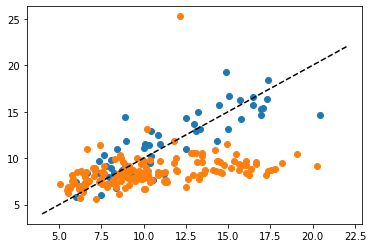

In [39]:
plt.scatter(y4_test, y4_pred)
plt.scatter(y0_test, y0_pred)
plt.plot([4,22], [4,22], 'k--')